In [5]:
import os
import json
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [3]:
def get_manta_files(folder="C:\\YandexDisk\\_QUT\\Project_1\\MAntas_imag\\0_manta_selected_annotated_some",
             pics_extension=('.jpg','.jpeg','.png')):
    '''
    getting collection of pictures with information regarding available lable file *.json
    the labelling was performed using "label me" tool https://github.com/wkentaro/labelme
    assuming that relevant label file has same name as image file and locatet in the same folder
    @params:
        folder:string
        pics_extension: iterable
        
    Oputputs:
        df : pandas.DataFrame
    '''
    df=pd.DataFrame(columns=['manta_name','file_name','image_path','body_landmark_path'])
    for dirname, dirnames, filenames in os.walk(folder):
        if len(filenames)>0:
            for f in filenames:
                if os.path.splitext(f)[1].lower() in pics_extension:
                    #print(os.path.splitext(f)[0].lower()+".json")
                    #print(set(filenames))
                    if os.path.splitext(f)[0]+".json" in set(filenames):
                        #print ("yes")
                        json_file=dirname+"\\"+os.path.splitext(f)[0]+".json"
                    else:
                        json_file=None
                    df.loc[len(df)]=[os.path.basename(dirname),os.path.splitext(f)[0],dirname+"\\"+f,json_file]
    print('total:'+str(len(df)))
    print('labelled:'+str(len(df[df.body_landmark_path.isnull()!=True])))
    return df

In [6]:
df=get_manta_files()
df.head(3)

total:1801
labelled:295


,manta_name,file_name,image_path,body_landmark_path
0,0002 Theola,2-F-20070711-LEI-MarkAtkinson-THEOLA-1,C:\YandexDisk\_QUT\Project_1\MAntas_imag\0_man...,C:\YandexDisk\_QUT\Project_1\MAntas_imag\0_man...
1,0002 Theola,2-F-20090320-NSI-MattPrunty-THEOLA,C:\YandexDisk\_QUT\Project_1\MAntas_imag\0_man...,C:\YandexDisk\_QUT\Project_1\MAntas_imag\0_man...
2,0002 Theola,2-F-20110623-0847-LEI-LydieCouturier-THEOLA-1,C:\YandexDisk\_QUT\Project_1\MAntas_imag\0_man...,C:\YandexDisk\_QUT\Project_1\MAntas_imag\0_man...


In [5]:
def distance(points):
    #returns eucledian distance for two n-dimentional points 
    a,b=points
    from scipy.spatial import distance
    return distance.euclidean(a, b)

def extract_body_landmarks(json_filename):
    '''extracts body-landmarks from json file
       @params:
           json_filename:string
       output - Dictionary:
           "height-width": tuple(height,width) of the source image
           "BLM"  : List of tuples. Each tuple is a body-landmark:
               (label,(x,y),r)
    '''
    if json_filename is None:
        return None
    
    with open(json_filename,'r',encoding='utf-8') as j:
              data=json.load(j)
    shapes=data['shapes']
    height_width=[data['imageHeight'],data['imageWidth']]
    
    json_info = {}
    json_info["height_width"] = height_width
    BLM=[]
    for t in shapes:
        label=t['label']
        point=np.array(t['points'][0][::-1])
        r=round(distance(t['points']))
        BLM.append((label,point,r))
    json_info["BLM"]=BLM
    return json_info

In [1]:
def gen_heatmaps(json_info,heatmap_size):
    '''
    produces array of pairs {heatmap_label:heatmap}
    @params: Dictionary:   (output from "extract_body_landmarks" )
           "height-width": tuple(height,width) of the source image
           "BLM"  : List of tuples. Each tuple is a body-landmark:
               (label,(x,y),r)
    outputs:
        list of Dictionaries:
            "label": String
            "hm" :heatmap - np.array
            "xy" : center of body landmark
    '''
    if json_info is None:
        return None
    BLMs=json_info["BLM"]
    height_width=json_info["height_width"]
    heatmaps=[]
    for poi in BLMs:
        poi_label=poi[0]
        point=np.array(poi[1])
        r=poi[2]

        heatmap=np.zeros(heatmap_size)
        #heatmap=np.array([[255]*heatmap_size[1]]*heatmap_size[0])
        scales=[]
        for d1,d2 in zip(height_width,heatmap_size):
            scales.append(d2/d1)
        scales=np.array(scales)
        #print(scales)
        newpoint=np.round(point*scales,0).astype(int)
        new_r=round(r*scales[0]).astype(int)*5
        if new_r==0: 
            new_r=1
        #print([newpoint,new_r])
        for x in range(newpoint[0]-new_r,newpoint[0]+new_r):
            for y in range(newpoint[1]-new_r,newpoint[1]+new_r):
                d=distance([newpoint,[x,y]])
                if d<new_r:
                    if x in range(heatmap_size[0]) and y in range(heatmap_size[1]):
                        heatmap[x,y]=round(255* (1-d/new_r))
        hm={}
        hm["label"]=poi_label
        hm["hm"]=heatmap
        hm["xy"]=newpoint
        heatmaps.append(hm)
    return heatmaps

fig, axes = plt.subplots(nrows=4, ncols=2,figsize=(15, 15))
#axes[1,1].set_title(0)
for i,h in zip(range(len(heatmaps)),heatmaps):   
    axes[i//2,i%2].imshow(h['hm'],cmap='Greys')
    axes[i//2,i%2].set_title(str(i)+" "+h["label"])
    #axes[i%2,i//2].set_axis_off()    
plt.show()

In [7]:
def apply_heatmaps(image,heatmaps):
    '''
    shows image and it's heatmaps
    @params:
        image:PIL.Image
        heatmaps: Manta Heatmaps list
    '''
    image_size=(heatmaps[0]["hm"].shape[::-1])
    #resize the image to size of heatmap
    image = image.resize(image_size, Image.ANTIALIAS)
    img=np.array(image)
    img= img/255

    base_mask=np.zeros_like(heatmaps[0]["hm"])
    #summarise all heatmaps into one
    for hm in heatmaps:
        base_mask=base_mask+hm["hm"]
    base_mask=base_mask/255
    #we want RED heatmap, so we have to add zero channels for Green and blue
    base_mask=base_mask.reshape(base_mask.shape[0],base_mask.shape[1],1)
    green=np.zeros_like(base_mask)
    blue=np.zeros_like(base_mask)
    mask=np.append(base_mask,green,axis=2)
    mask=np.append(mask,blue,axis=2)

    newpic=(base_mask==0)*img + (base_mask!=0)*(img*(1-base_mask) + mask)
    plt.imshow(newpic)
    #add anotations
    for heatmap in heatmaps:
        plt.annotate(heatmap["label"],xy=(heatmap["xy"][1]+5,heatmap["xy"][0]))


C:\YandexDisk\_QUT\Project_1\MAntas_imag\0_manta_selected_annotated_some\0012 Laverna\12-F-20091112-LEI_SD-FabriceJaine-LAVERNA-1.json
{'BLM': [('left-eye', array([279, 614]), 46.0), ('right-eye', array([ 755, 1247]), 47.0), ('left-gill', array([1174,  937]), 21.0), ('right-gill', array([1461, 1412]), 46.0), ('tail', array([2851,  952]), 76.0)], 'height_width': [3648, 2736]}


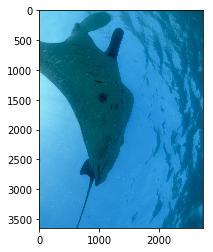

In [8]:
pic_to_show=70

image_path=df.image_path[pic_to_show]
jpath=df.body_landmark_path[pic_to_show]
#jpath="C:\\YandexDisk\\_QUT\\Project_1\\MAntas_imag\\0_manta_selected_annotated_some\\0012 Laverna\\12-F-20130627-LEI-MichelleOoi-LAVERNA-2.json"
print(jpath)
json_info = extract_body_landmarks(jpath)
print(json_info)
heatmaps=gen_heatmaps(json_info)

from PIL import Image
image = Image.open(image_path)
plt.imshow(image)

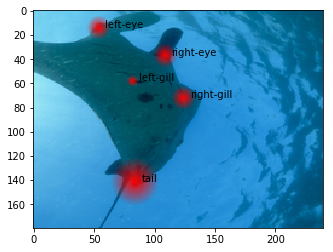

In [9]:
apply_heatmaps(image,heatmaps)

In [10]:
def image_to_numpy(image,image_size):
    image = image.resize(image_size, Image.ANTIALIAS)
    img=np.array(image)
    return img/255

In [11]:
def heatmaps_to_numpy(heatmaps):
    '''
    uncompleted
    '''
    #numpy_heatmaps=np.array()
    hm={}
    labels=['left-eye','right-eye','left-gill','right-gill''tail']
    for h in heatmaps:
        hm[h["label"]]=h["hm"]
    if "tail" in hm.keys():
        return hm["tail"]/255
    else:
        return None
    for l in labels:
        if l in hm.keys():
            numpy_heatmaps=np.append(numpy_heatmaps,hm[l],axis=0)
        else:
            numpy_heatmaps=np.append(numpy_heatmaps,np.zeros_like(heatmaps[0]["hm"]),axis=0)
    

0.00968945170660857
(180, 240)


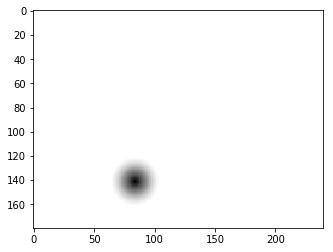

In [12]:

nphm=heatmaps_to_numpy(heatmaps)
plt.imshow(nphm,cmap="Greys")
print(heatmaps_to_numpy(heatmaps).mean())
print(nphm.shape)